In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Fiat.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_500 Ailesi,Seri_Albea,Seri_Brava,...,Model_Sole 1.4 Fire Dynamic,Model_Sole 1.4 Fire Dynamic Plus,Model_Sole 1.4 Fire Premio,Model_Sole 1.4 Fire Premio Plus,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,352750,-0.090909,-0.694444,-0.923077,0.599251,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,488000,0.545455,0.500000,0.182692,0.232210,5.0,3.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,630000,0.909091,-0.194444,-0.923077,-1.044569,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,750000,1.090909,-0.194444,-0.923077,-1.302622,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,425000,0.636364,-0.194444,-1.500000,0.052434,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_7444\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,34543.027285,1.076557e+09,32810.925452,23511.354703


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:51:07,037] A new study created in memory with name: no-name-5647b759-47d5-42a2-8f23-fbc2514b19ea
[I 2023-05-23 20:51:07,314] Trial 3 finished with value: 380197.26446808234 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.005341989254242112, 'max_depth': 4, 'min_child_weight': 190}. Best is trial 3 with value: 380197.26446808234.
[I 2023-05-23 20:51:07,344] Trial 5 finished with value: 283342.193824417 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.038495610936413655, 'max_depth': 13, 'min_child_weight': 233}. Best is trial 5 with value: 283342.193824417.
[I 2023-05-23 20:51:07,346] Trial 1 finished with value: 398465.59497426404 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.00026429141416134286, 'max_depth': 3, 'min_child_weight': 150}. Best is trial 5 with value: 283342.193824417.
[I 2023-05-23 20:51:07,390] Trial 0 finished with value: 342219.906401685 and parameters: {'co

[I 2023-05-23 20:51:09,248] Trial 30 finished with value: 108803.93360515672 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.13175403224970242, 'max_depth': 5, 'min_child_weight': 21}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:09,311] Trial 31 finished with value: 151541.66834597127 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.09778071330066733, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:09,316] Trial 32 finished with value: 114670.54295059279 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1256601122515362, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:09,391] Trial 33 finished with value: 131083.37186178888 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.11278394143338183, 'max_depth': 8, 'min_child_weight': 

[I 2023-05-23 20:51:11,313] Trial 61 finished with value: 210847.03914186798 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.06661486932114957, 'max_depth': 11, 'min_child_weight': 49}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:11,344] Trial 60 finished with value: 213569.52893429945 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.06623194053976374, 'max_depth': 11, 'min_child_weight': 127}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:11,494] Trial 62 finished with value: 52867.98993842185 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3463597575509841, 'max_depth': 3, 'min_child_weight': 161}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:11,578] Trial 64 finished with value: 46935.43699925767 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.38286661720625365, 'max_depth': 14, 'min_child_weig

[I 2023-05-23 20:51:14,384] Trial 91 finished with value: 39579.07197131326 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4851648779591709, 'max_depth': 3, 'min_child_weight': 131}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:14,386] Trial 90 finished with value: 36044.20339083769 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.49989042138639017, 'max_depth': 3, 'min_child_weight': 15}. Best is trial 16 with value: 33751.48711240402.
[I 2023-05-23 20:51:14,551] Trial 92 finished with value: 33119.85184484893 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.39707564221692954, 'max_depth': 13, 'min_child_weight': 15}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:14,566] Trial 95 finished with value: 65127.79336863183 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.20503068125052665, 'max_depth': 13, 'min_child_weight':

[I 2023-05-23 20:51:16,780] Trial 121 finished with value: 41268.21791868052 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.26854557766887605, 'max_depth': 15, 'min_child_weight': 22}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:16,796] Trial 120 finished with value: 33906.452798052254 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.379488013971519, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:17,072] Trial 123 finished with value: 76636.09624419788 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.17333469220225742, 'max_depth': 14, 'min_child_weight': 56}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:17,098] Trial 122 finished with value: 40769.67858743921 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2859702586524704, 'max_depth': 14, 'min_child_weigh

[I 2023-05-23 20:51:19,692] Trial 150 finished with value: 42479.26070359463 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.252278280453072, 'max_depth': 14, 'min_child_weight': 18}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:19,702] Trial 149 finished with value: 44157.32051868489 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.24425341442451015, 'max_depth': 14, 'min_child_weight': 16}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:19,772] Trial 152 finished with value: 34435.844300988545 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.41811578726042015, 'max_depth': 14, 'min_child_weight': 17}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:19,773] Trial 153 finished with value: 44613.22195267782 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.24192352125642674, 'max_depth': 14, 'min_child_wei

[I 2023-05-23 20:51:22,302] Trial 179 finished with value: 35067.76808141481 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3460498786650374, 'max_depth': 15, 'min_child_weight': 4}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:22,326] Trial 181 finished with value: 33702.262279296396 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.36873604465400855, 'max_depth': 15, 'min_child_weight': 5}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:22,361] Trial 182 finished with value: 33204.938806869075 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3611697638618698, 'max_depth': 15, 'min_child_weight': 5}. Best is trial 92 with value: 33119.85184484893.
[I 2023-05-23 20:51:22,375] Trial 183 finished with value: 33419.78380850507 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3595202979111884, 'max_depth': 15, 'min_child_weight

[I 2023-05-23 20:51:24,844] Trial 209 finished with value: 33990.628564541104 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.34695198497071494, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 202 with value: 32822.294711734125.
[I 2023-05-23 20:51:25,474] Trial 211 finished with value: 33810.90742838599 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.3354120731849613, 'max_depth': 15, 'min_child_weight': 9}. Best is trial 202 with value: 32822.294711734125.
[I 2023-05-23 20:51:25,515] Trial 213 finished with value: 34104.24036292778 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.329452275942708, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 202 with value: 32822.294711734125.
[I 2023-05-23 20:51:25,551] Trial 214 finished with value: 34611.7876111254 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.319689022647032, 'max_depth': 15, 'min_child_we

[I 2023-05-23 20:51:27,956] Trial 240 finished with value: 33401.525606351155 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.42508970044765965, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 227 with value: 32771.73204124934.
[I 2023-05-23 20:51:28,490] Trial 244 finished with value: 34133.850675123715 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4987677864872801, 'max_depth': 14, 'min_child_weight': 24}. Best is trial 227 with value: 32771.73204124934.
[I 2023-05-23 20:51:28,537] Trial 241 finished with value: 34096.616752238784 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.49874958716903595, 'max_depth': 15, 'min_child_weight': 25}. Best is trial 227 with value: 32771.73204124934.
[I 2023-05-23 20:51:28,538] Trial 242 finished with value: 33985.95805418152 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4353801000896199, 'max_depth': 14, 'min_chil

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 32771.7320
Best params:
	colsample_bytree: 1.0
	subsample: 0.8
	learning_rate: 0.4171616966956799
	max_depth: 15
	min_child_weight: 7


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,15],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [0.8],
               'min_child_weight': [7]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
{'TestDeger': 36736.354535925886, 'MSE': 1107129967.2733214, 'RMSE': 33273.56258763587, 'MAE': 24704.832609749647}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9617771145078153

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9563958387035326

In [17]:
marka_model = joblib.dump(grid_final_model, "Fiat.pkl")

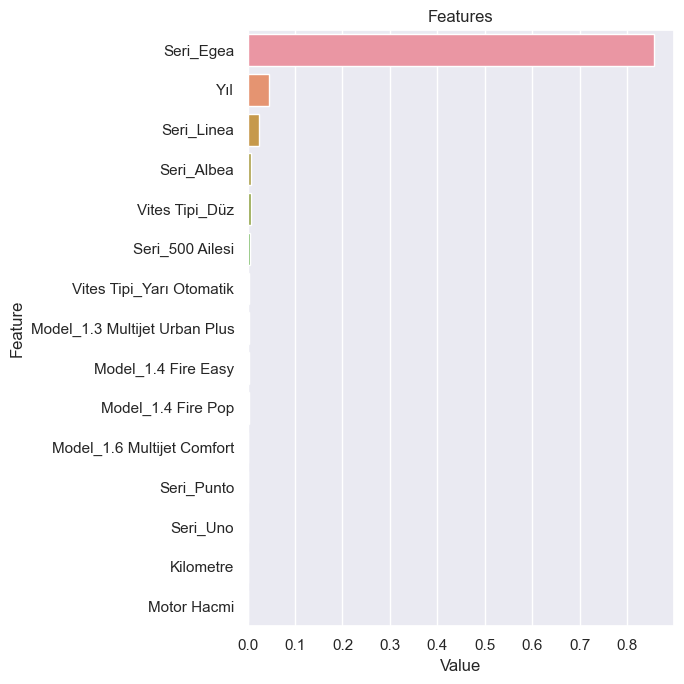

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)